# Adversarial Robust Deep Hedging
#### Exploring the Black-Scholes Model
(Example 7.3)

In [1]:
from typing import Dict
from IPython import display
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.DeepHedgeTrainer import DeepHedgeTrainer, DeepHedgeTrainerConfig
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.gan.RobustDhGan import RobustDhGan
from src.generator.BlackScholesCoefficient import BlackScholesCoefficientConfig, BlackScholesDriftCoefficient, BlackScholesDiffusionCoefficient
from src.generator.SdeGenerator import GeneratorConfig, SdeGenerator
from src.util.processes.BlackScholesGenerator import BlackScholesGenerator
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainerConfig
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.penalty.CompareVolatility import CompareVolatility, VolatilityComparisonConfig
from src.util.TimeUtil import UniformTimeDiscretization
from src.util.processes.BlackScholesGenerator import BlackScholesParameterSet, BlackScholesGenerator
from src.util.processes.BrownianMotionGenerator import BrownianMotionGenerator
from src.util.processes.HestonGenerator import HestonParameterSet, HestonGenerator
from src.util.torch_util.AdapterUtil import Adapter, AdapterList, SelectDimensions, ConvertToIncrements
from src.util.torch_util.TrainingUtil import TrainerConfig
from src.util.torch_util.CallbackUtil import PrintMetrics, PrintGeneratorParameters, PrintEmptyLine
from src.util.VisualizationUtil import QuantityLogger
from src.util.torch_util.TrainingUtil import TrainerConfig, PbarOption, gen_factory
from src.util.ray_util.TqdmUtil import to_limited_iterator
from src.util.PushOverUtil import notify

In [2]:
import ray
import logging
ray.shutdown()
ray.init(num_cpus=10, logging_level=logging.ERROR)

Python version:,3.8.0
Ray version:,2.0.0


## Initialize

### Reference model and generator 

We begin by initializing the true market model. We choose the following paramters for demonstration. 

In [3]:
bs_parameters = BlackScholesParameterSet(drift=0.0, sigma=0.2)
initial_asset_price = 1.0

Moreover, we need the following market parameters:

In [4]:
trading_freq: int = 5
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)

This allows us to define a generator for the true underlying model: 

In [5]:
reference_generator = BlackScholesGenerator(
    drift=np.array([bs_parameters.drift]),
    sigma=np.array([bs_parameters.sigma]),
).provide_generator(
    initial_value=np.array([initial_asset_price]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)

### Generate small data environments

We now generate `number_of_scenarios` scenarios, where we only few paths from the reference model given.

In [6]:
number_of_scenarios = 500

In [7]:
scenarios = [reference_generator(30) for _ in range(number_of_scenarios)] 

### Define corresponding penalties

We can now initialize penalties that determine the distance to the generated paths in each scenario. 

In [8]:
pen_config = VolatilityComparisonConfig(td)
penalizers = [
    CompareVolatility(scenario, pen_config, transform=lambda x: 5 * x) for scenario in scenarios # 0.8
]

They measure the distance of generated paths by considering the distance to the heuristic volatility. 

In [9]:
volatilities_for_scenarios = [torch.mean(pen.original_volatility).item() for pen in penalizers]
# volatilities_for_scenarios = np.ones(50)*0.17

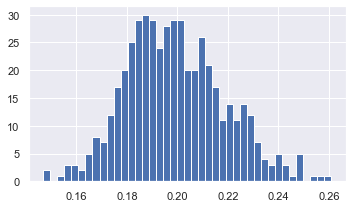

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(5,3))
axs.hist(volatilities_for_scenarios, bins=41)
plt.tight_layout()
plt.show()

### Initialize generators

With this, we can now initialize an `SdeGenerator` that has `BlackScholesCoefficient` corresponding to the above estimates. 

Note that formally these would be calibrated to the data in this step, but we omit this, since the result is obviously equivalent. 

In [11]:
generators = []
for vol in volatilities_for_scenarios:
    coef_config = BlackScholesCoefficientConfig(
        BlackScholesParameterSet(drift=bs_parameters.drift, sigma=vol),
        initial_asset_price=1.0,
    )
    drift_coef, diffusion_coef = BlackScholesDriftCoefficient(coef_config), BlackScholesDiffusionCoefficient(coef_config)
    gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
    generators.append(SdeGenerator(generator_config=gen_config))

We disable the training for all drift parameters:

In [12]:
for g in generators:
    g.drift.drift.requires_grad = False

### Noise Generator
In order to utilize the generator, we require a noise generator. In this case, this is a simple Brownian motion generator:

In [13]:
noise_generator = BrownianMotionGenerator().provide_increment_generator(
    initial_value=np.zeros(1),
    times=td.times,
    random_number_generator=np.random.default_rng(4444),
)

We can now verify that the generators are initialized accordingly.

In [14]:
# initialization_errors = [p(g(noise_generator(1000))).item() for g, p in tqdm(zip(generators, penalizers), total=1000)]

In [15]:
# fig, axs = plt.subplots(1, 1, figsize=(5,3))
# axs.hist(initialization_errors, bins=41)
# plt.tight_layout()
# plt.show()

## Deep Hedging

We will now train a deep hedge on each of the individual models. This has tow purposes

1. we use these deep hedges as pre-trained components for the actual application of the robust hedge GAN, and
2. we will use these hedges to compare the robust hedge GAN on out-of-sample generated data against.

### Initialization 

We begin by setting a hedging objective, since it remains the same over all models. 

In [16]:
hedge_objective = MeanVariance(84)

Next, we define the deep hedges.

In [17]:
ref_hedge = DeepHedge(DeepHedgeConfig(
    derivative,
    torch.tensor([initial_asset_price], dtype=torch.float32),
    StrategyNetConfig(
        dim_of_information_process=1,
        dim_of_tradable_asset=1,
        number_of_layers=2,
        nodes_in_intermediate_layers=100,
    ),
))

In [18]:
deep_hedges = []
for g in generators:
    strategy_config = StrategyNetConfig(
        dim_of_information_process=1,
        dim_of_tradable_asset=1,
        number_of_layers=2,
        nodes_in_intermediate_layers=100,
    )
    initial_asset_price_for_deep_hedge = torch.tensor([initial_asset_price], dtype=torch.float32)
    deep_hedges.append(DeepHedge(DeepHedgeConfig(derivative, initial_asset_price_for_deep_hedge, strategy_config)))

### Training

We will now train each individual hedge on the corresponding generator. For this we will use 

In [19]:
sample_size = 100000
batch_sizes_for_epoch = [100]*3 + [1000]*1 + [10000]*2
target_folder = 'resources/network-states/bs_test_v3'

In [20]:
ref_hedge_address = f'{target_folder}/ref_hedge.pt'
ref_dht = DeepHedgeTrainer(
    dh=ref_hedge,
    config=DeepHedgeTrainerConfig(hedge_objective),
    trainer_config=TrainerConfig(sample_size, gen_factory(g, noise_generator), None),
)
torch.save(
    ref_dht.get_weights_from_load_and_fitting_procedure(
        f=ref_hedge_address,
        batch_sizes=batch_sizes_for_epoch,
        pbar_option=PbarOption.VANISHING_BATCH_BAR,
    ), 
    ref_hedge_address,
) 

In [21]:
sample_size = 10000
batch_sizes_for_epoch = 10*[100] + 10*[5000] 

In [22]:
@ray.remote
def train_dh_remote(i, g, dh, hedge_objective, sample_size, noise_generator):
    dht_config = DeepHedgeTrainerConfig(hedge_objective)
    t_config = TrainerConfig(sample_size, gen_factory(g, noise_generator), None)
    dht = DeepHedgeTrainer(
        dh=dh,
        config=dht_config,
        trainer_config=t_config,
    )
    return i, dht.get_weights_from_load_and_fitting_procedure(
        f=f'{target_folder}/hedge_parameters_{i}.pt',
        batch_sizes=batch_sizes_for_epoch,
        pretrained=ref_hedge_address,
        loss_curve_address=f'{target_folder}/hedge_loss_curve_{i}'
    )
    

In [23]:
id_gen = (train_dh_remote.remote(
    i=i,
    dh=dh,
    g=g,
    hedge_objective=hedge_objective,
    sample_size=sample_size,
    noise_generator=noise_generator,
) for i, (dh, g) in enumerate(zip(deep_hedges, generators)))

In [24]:
for i, state_dict in tqdm(to_limited_iterator(id_gen, 12), total=len(deep_hedges)):
    deep_hedges[i].load_state_dict(state_dict)
    torch.save(deep_hedges[i].state_dict(), f'{target_folder}/hedge_parameters_{i}.pt') 

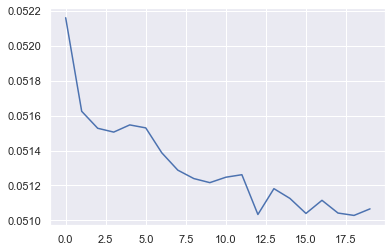

In [25]:
for i in [22]:
    plt.plot(np.load(f'{target_folder}/hedge_loss_curve_{i}.npy', allow_pickle=True))

### Testing 

In [26]:
# (We initialize the reference generator to reset the RNG)
reference_generator = BlackScholesGenerator(
    drift=np.array([bs_parameters.drift]),
    sigma=np.array([bs_parameters.sigma]),
).provide_generator(
    initial_value=np.array([initial_asset_price]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)
test_data = torch.diff(reference_generator(10000), 1, 1)

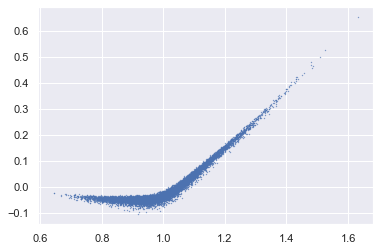

In [27]:
ref_hedge.eval()
deep_hedge_results = np.sum(ref_hedge(test_data).detach().numpy() * test_data.numpy(), axis=(1, 2))
terminal_values_on_test = np.sum(test_data.numpy(), axis=1)[:, 0] + 1.0
plt.scatter(terminal_values_on_test, deep_hedge_results, s=.1)
ref_hedge.train()
plt.show()

In [28]:
@ray.remote
def compute_hedge_objective(i, dh):
    return i, hedge_objective(dh(test_data)).item()

oosp_dict = {i: p for i, p in to_limited_iterator((compute_hedge_objective.remote(i=i, dh=dh) for i, dh in tqdm(enumerate(deep_hedges))), 12)}
oosp = [oosp_dict[i] for i, _ in enumerate(deep_hedges)]

In [29]:
# oosp = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

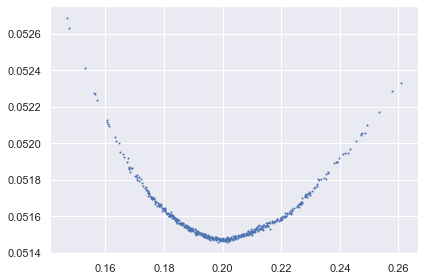

In [30]:
plt.scatter(volatilities_for_scenarios, oosp, s=1)
plt.tight_layout()
plt.show()

### Robust Hedge GAN

In [31]:
sample_size = 10000
batch_sizes_for_epoch = 10*[1000] + 10*[5000]

In [32]:
# i = 0
# dh = deep_hedges[i]
# p = penalizers[i]
# g = generators[i]
# dht_config = DeepHedgeTrainerConfig(
#     hedge_objective=hedge_objective,
#     generation_adapters=AdapterList([ConvertToIncrements()]),
# )
# gt_config = SdeGeneratorTrainerConfig(
#     penalizer=p,
#     penalization_adapters=AdapterList([]),
# )
# t_config = TrainerConfig(sample_size, noise_generator, None)
# rhg = RobustDhGan(
#     dh=dh, 
#     hedge_config=dht_config,
#     gen=g,
#     gen_config=gt_config,
#     trainer_config=t_config,
# )
# 
# rhg.fit(
#     batch_sizes=batch_sizes_for_epoch,
#     pbar_option=PbarOption.EPOCH_BAR,
#     loss_curve_address=f'{target_folder}/0000_example_loss_curve',
# )
# 
# fig, axs = plt.subplots(1, 3, figsize = (12, 4))
# for i, ax in enumerate(axs):
#     ax.plot(np.load(f'{target_folder}/0000_example_loss_curve.npy', allow_pickle=True)[:, i])
# 
# dh.eval()
# deep_hedge_results = np.sum(dh(test_data).detach().numpy() * test_data.numpy(), axis=(1, 2))
# terminal_values_on_test = np.sum(test_data.numpy(), axis=1)[:, 0] + 1.0
# plt.scatter(terminal_values_on_test, deep_hedge_results, s=.1)
# dh.train()
# plt.show()

In [33]:
robust_dh_gans = []
for dh, p, g in zip(deep_hedges, penalizers, generators):
    dht_config = DeepHedgeTrainerConfig(
        hedge_objective=hedge_objective,
        generation_adapters=AdapterList([ConvertToIncrements()]),
    )
    gt_config = SdeGeneratorTrainerConfig(
        penalizer=p,
        penalization_adapters=AdapterList([]),
    )
    t_config = TrainerConfig(sample_size, noise_generator, None)
    robust_dh_gans.append(RobustDhGan(
        dh=dh, 
        hedge_config=dht_config,
        gen=g,
        gen_config=gt_config,
        trainer_config=t_config,
    ))

In [34]:
@ray.remote
def train_rhgan_remote(i, rhg):
    return i, rhg.get_weights_from_load_and_fitting_procedure(
        f=f'{target_folder}/rhgan_parameters_{i}.pt',
        batch_sizes=batch_sizes_for_epoch,
        loss_curve_address=f'{target_folder}/rhgan_loss_curve_{i}',
    )
    

In [35]:
id_gen = (train_rhgan_remote.remote(i=i, rhg=rhg) for i, rhg in enumerate(robust_dh_gans))

In [36]:
for i, state_dict in tqdm(to_limited_iterator(id_gen, 12), total=len(robust_dh_gans)):
    robust_dh_gans[i].load_state_dict(state_dict)
    torch.save(robust_dh_gans[i].state_dict(), f'{target_folder}/rhgan_parameters_{i}.pt') 

(train_rhgan_remote pid=60728) /usr/local/anaconda3/envs/ARDH/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_rhgan_remote pid=60728)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
(train_rhgan_remote pid=60735) /usr/local/anaconda3/envs/ARDH/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_rhgan_remote pid=60735)   warnings.warn("Seems like `optimizer.step

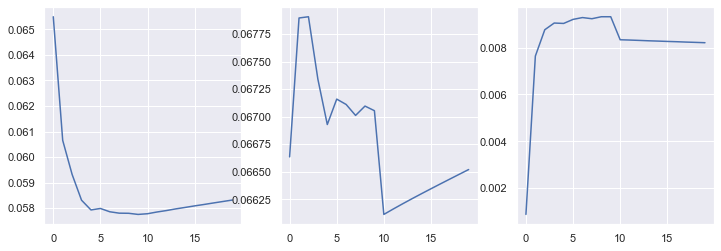

In [51]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
for i, ax in enumerate(axs):
    ax.plot(np.load(f'{target_folder}/rhgan_loss_curve_7.npy', allow_pickle=True)[:, i])

## Training

In [38]:
oosp_robust = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

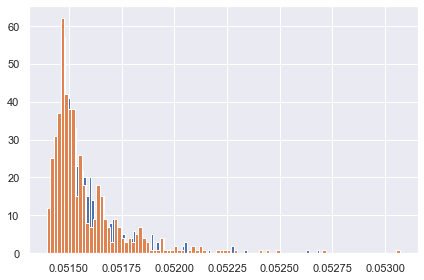

In [39]:
no_bins = 100
plt.hist(oosp, bins=no_bins)
plt.hist(oosp_robust, bins=no_bins)
plt.tight_layout()
plt.show()

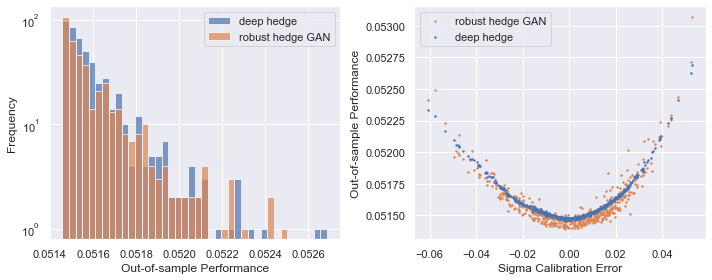

*** SIGTERM received at time=1666183280 ***
PC: @     0x7fff206e3c3a  (unknown)  kevent
[2022-10-19 13:41:20,890 E 60712 16212191] logging.cc:361: *** SIGTERM received at time=1666183280 ***
[2022-10-19 13:41:20,890 E 60712 16212191] logging.cc:361: PC: @     0x7fff206e3c3a  (unknown)  kevent


In [54]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

vals_n, bins = np.histogram(oosp, bins=40)
vals_r = np.histogram(oosp_robust, bins=bins)[0]
bin_centers = 0.5*(bins[1:]+bins[:-1])
axs[0].hist(oosp, bins=bins, label='deep hedge', color='C0', alpha=.7)
axs[0].hist(oosp_robust, bins=bins, label='robust hedge GAN', color='C1', alpha=.7)
axs[0].set_xlabel('Out-of-sample Performance')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')
axs[0].legend()
# axs[0].set_title('')

axs[1].scatter([bs_parameters.sigma - v for v in volatilities_for_scenarios], oosp_robust, label='robust hedge GAN', s=2, c='C1')
axs[1].scatter([bs_parameters.sigma - v for v in volatilities_for_scenarios], oosp, label='deep hedge', s=2, c='C0')
axs[1].set_xlabel('Sigma Calibration Error')
axs[1].set_ylabel('Out-of-sample Performance')
axs[1].legend()
# axs[1].set_title()

plt.tight_layout()
# plt.savefig('figs/BlackScholesRobustification.pdf')
plt.show()

In [41]:
print('Naive:  ', np.mean(oosp))
print('Robust: ', np.mean(oosp_robust))
print()
print('Naive:  ', np.std(oosp))
print('Robust: ', np.std(oosp_robust))

Naive:   0.05160683248192072
Robust:  0.051579540058970454

Naive:   0.00016988209112276469
Robust:  0.00019164793169050342


In [42]:
notify()

In [43]:
np.std(oosp_robust)/np.std(oosp)

1.1281232201928202

In [44]:
# torch.save(dh.state_dict(), 'resources/network-states/deep_hedge_for_heston.pt')

### Loss curves

In [45]:
i = 0

In [46]:
coef_config = BlackScholesCoefficientConfig(
    BlackScholesParameterSet(drift=bs_parameters.drift, sigma=volatilities_for_scenarios[i]),
    initial_asset_price=1.0,
)
drift_coef, diffusion_coef = BlackScholesDriftCoefficient(coef_config), BlackScholesDiffusionCoefficient(coef_config)
gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
g = SdeGenerator(generator_config=gen_config)

In [47]:
strategy_config = StrategyNetConfig(dimension_of_asset=1, number_of_layers=3, nodes_in_intermediate_layers=36)
initial_asset_price_for_deep_hedge = torch.tensor([initial_asset_price], dtype=torch.float32)
dh = DeepHedge(DeepHedgeConfig(derivative, initial_asset_price_for_deep_hedge, strategy_config))
dh.load_state_dict(torch.load(f'resources/network-states/bs_test/scenario_{i}.pt'))

TypeError: __init__() got an unexpected keyword argument 'dimension_of_asset'

In [ ]:
g_opt = torch.optim.Adam(g.parameters())
gen_adapters = AdapterList([])
gen_train_config = SdeGeneratorTrainerConfig(g, penalizers[i], g_opt, gen_adapters)

h_opt = torch.optim.Adam(dh.parameters())
hedge_adapters = AdapterList([ConvertToIncrements()])
dh_train_config = DeepHedgeTrainerConfig(dh, hedge_objective, h_opt, hedge_adapters)

In [ ]:
batches = [noise_generator(1000) for _ in range(100)]

In [ ]:
h_losses = QuantityLogger()
g_losses = QuantityLogger()
p_losses = QuantityLogger()

for batch in batches:
    generated = g(batch)
    profit_and_loss = dh(dh_train_config.generation_adapters(generated))
    hedge_loss = hedge_objective(profit_and_loss)
    dh.zero_grad()
    hedge_loss.backward()
    dh_train_config.optimizer.step()
    dh_train_config.scheduler.step()
    h_losses.update(hedge_loss.item())
    
    generated = g(batch)
    profit_and_loss = dh(dh_train_config.generation_adapters(generated))
    hedge_loss = hedge_objective(profit_and_loss)
    penalty = penalizers[i](gen_train_config.penalization_adapters(generated))
    generation_loss = penalty - hedge_loss
    g.zero_grad()
    generation_loss.backward()
    gen_train_config.optimizer.step()
    gen_train_config.scheduler.step()
    g_losses.update(generation_loss.item())
    p_losses.update(penalty.item())

In [ ]:
import mpl_axes_aligner

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(np.load('resources/network-states/bs_test/losses.npz', allow_pickle=True)['scenario_0'], label='Hedge Loss')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].legend()
# axs[0].set_title()

axs[1].plot(h_losses.history, c='C0', label='Hedge Loss')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss')
# axs[1].set_title('')

axs_clone = axs[1].twinx()
axs_clone.plot(g_losses.history, c='C1', label='Generation Loss')
axs[1].legend()
axs_clone.legend(loc='lower left')

axs_clone.grid(False)

mpl_axes_aligner.align.yaxes(axs[1], h_losses.history[0], axs_clone, g_losses.history[0])

plt.tight_layout()
# plt.savefig('figs/BlackScholesLossCurves.pdf')
plt.show()

In [ ]:
print(g_losses.history[0])
print(h_losses.history[0])

In [ ]:
dh.load_state_dict(torch.load('resources/network-states/deep_hedge_for_heston.pt'))
robust_dh_gan.hedge_config.reset_scheduler()

In [ ]:
inputs = torch.diff(heston_generator(5000), 1, 1)[:, :, 0:1]

In [ ]:
dh.eval()
n_res = np.sum(dh(inputs).detach().numpy() * inputs.numpy(), axis=(1, 2))
term_a_v = np.sum(inputs.numpy(), axis=1)[:, 0] + 1.0

In [ ]:
plt.scatter(term_a_v, n_res, s=.1)
plt.show()

In [ ]:
# This is not necessary, we start with the optimal initialization.
# robust_dh_gan.deactivate_hedge_training()
# robust_dh_gan.fit(5, callbacks=[PrintHestonParameters()])
# robust_dh_gan.activate_hedge_training()

In [ ]:
dh.train()
generator.train()
robust_dh_gan.activate_generation_training()
robust_dh_gan.fit(100, callbacks=[PrintMetrics()])

In [ ]:
dh.eval()
r_res = np.sum(dh(inputs).detach().numpy() * inputs.numpy(), axis=(1, 2))
term_a_v = np.sum(inputs.numpy(), axis=1)[:, 0] + 1.0

In [ ]:
plt.scatter(term_a_v, r_res, s=.1)
plt.scatter(term_a_v, n_res, s=.1)
plt.show()

In [ ]:
plt.scatter(term_a_v, r_res - n_res, s=.1)